# This code builds an autoencoder model from color, cropped face images. 

In [1]:
!pip3 uninstall keras
!pip3 uninstall tensorflow

!pip3 install keras==2.3.1
!pip3 install tensorflow==2.2.0

Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.9.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.9.0
Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.2
y
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 37.0 MB/s 
     |███████████████

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
print(tf.__version__)
# print(tensorflow.__version__)

2.2.0


In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import random as rn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.6 MB/s 
time: 420 µs (started: 2022-11-20 13:58:42 +00:00)


In [6]:
# Set seed for reproducibility.

set_seed = 42
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 968 µs (started: 2022-11-20 13:58:42 +00:00)


In [7]:
f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"

time: 360 µs (started: 2022-11-20 13:58:42 +00:00)


In [8]:
# Some reference codes for building autoencoders for color images.
# https://blog.keras.io/building-autoencoders-in-keras.html
# https://keras.io/examples/vision/autoencoder/

def create_autoencoder():
    # Define the model
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #2nd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #3rd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    #1st deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    #2nd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))

    #3rd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))    

    model.add(Conv2D(3,(3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

time: 3.22 ms (started: 2022-11-20 13:58:42 +00:00)


In [11]:
# Generate data from the images in a folder.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

batch_size = 64
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', validation_split=0.1)
train_generator = train_datagen.flow_from_directory(
    f_PATH+'image/multi-label/train',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='input',
    classes=[''],
    subset='training'
    )
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', validation_split=0.1)
validation_generator = test_datagen.flow_from_directory(
    f_PATH+'image/multi-label/valid',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='input',
    classes=[''],
    subset='validation'
    )

Found 27948 images belonging to 1 classes.
Found 388 images belonging to 1 classes.
time: 1min 3s (started: 2022-11-20 14:01:02 +00:00)


In [ ]:
# Train the autoencoder.

checkpoint_path = f_PATH+"model/autoencoder.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)    
autoencoder = create_autoencoder()

history = autoencoder.fit_generator(
        train_generator,
        steps_per_epoch=34936 // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=3881 // batch_size,
        callbacks=[cp_callback])    

Instructions for updating:
Please use Model.fit, which supports generators.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

dict_keys(['loss', 'val_loss'])


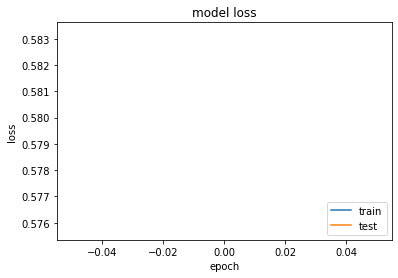

time: 172 ms (started: 2022-11-20 07:13:17 +00:00)


In [ ]:
# Summarize history for loss.

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
# Test the model

sample = validation_generator.next()

# Generate noisy image
noisy_img = np.zeros(sample[0][0].shape, np.float32)

mean = 0
sigma = 0.05

gaussian = np.random.normal(mean, sigma, (sample[0][0].shape[0], sample[0][0].shape[1]))
gaussian = gaussian[..., np.newaxis]
#gaussian.shape

noisy_sample = []
for img in sample[0]:
    noisy_img = img + gaussian
    noisy_sample.append(noisy_img)

noisy_sample = np.array(noisy_sample)
noisy_sample.shape

denoised = autoencoder.predict(noisy_sample)
#denoised.shape
#denoised[0].shape

2/2 [==============================] - 0s 7ms/step
time: 481 ms (started: 2022-11-20 07:13:18 +00:00)


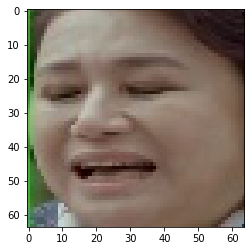

time: 162 ms (started: 2022-11-20 07:13:18 +00:00)


In [ ]:
# original image
plt.imshow(sample[0][0])

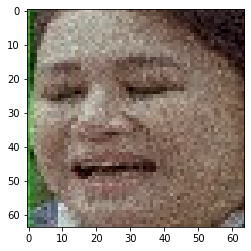

time: 192 ms (started: 2022-11-20 07:13:18 +00:00)


In [ ]:
# noisy image
noisy_img = sample[0][0] + gaussian
plt.imshow(noisy_img)

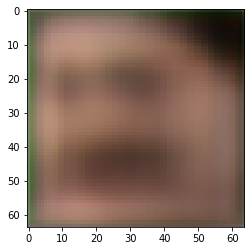

time: 158 ms (started: 2022-11-20 07:13:19 +00:00)


In [ ]:
# denoised image
plt.imshow(denoised[0])

### Load the autoencoder weights.

In [ ]:
# Use the crate_autoencder() function to build the model frame.

autoencoder = create_autoencoder()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_7 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

In [ ]:
# Specify the path to autoencoder model weights and load the weights.
checkpoint_path = f_PATH+"model/autoencoder.ckpt"
autoencoder.load_weights(checkpoint_path)

time: 228 ms (started: 2022-11-20 07:13:19 +00:00)
